In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import shannon

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

# Information analysis  
  
  Still some aspects of this analysis are counter-intuitive. For instance, the horizontal weight should presumably be much lower for such a high SNR. And why don't we see diverse horizontal weights? Let's move to an analysis where we specifically compute the mutual information.

In [4]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [5]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [6]:
blah = generate_spatial_signals(10000)

In [7]:
blah.shape

(10000, 398)

In [8]:
sigma_x = np.cov(blah.T, ddof=1)

In [9]:
sigma_x.shape

(398, 398)

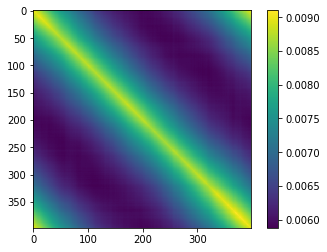

In [10]:
plt.imshow(sigma_x)
plt.colorbar()

In [17]:
sigma_x.shape

(398, 398)

In [18]:
diag = np.diag(np.linalg.cholesky(sigma_x))

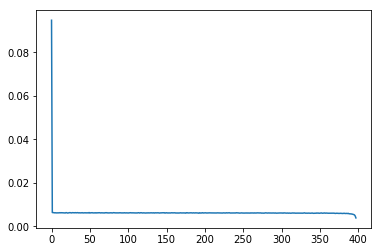

In [19]:
plt.plot(diag)

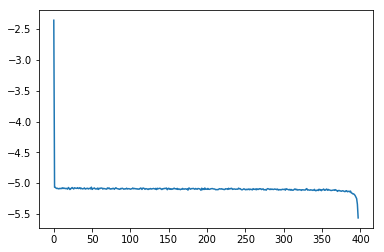

In [20]:
plt.plot(np.log(diag))

In [21]:
2 * np.sum(np.log(diag))

-4055.5217654769463

In [23]:
def mutual_information(x, y):
    '''Mutual information between two multivariate Gaussians.
    
    Args:
        x: 2d array with each row representing a variable, and each
            column a single observation of all those variables.
        y: 2d array with each row representing a variable, and each
            column a single oberservation of all those variables.
    Returns:
        info: Mutual information between x and y in nats.
    '''
    x_vars = x.shape[0]
    y_vars = y.shape[0]
    x_obs = x.shape[1]
    y_obs = y.shape[1]
    assert x_obs == y_obs, 'X and Y must have the same number of observations.'
    
    cov_x = np.cov(x, ddof=1)
    cov_y = np.cov(y, ddof=1)
    cov_xy = np.cov(np.vstack([x, y]), ddof=1)
    
    # entropy_x = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_x))
    # entropy_y = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_y))
    # entropy_xy = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_xy))
#     inside_x = np.linalg.det(2 * np.pi * np.e * cov_x)
#     inside_y = np.linalg.det(2 * np.pi * np.e * cov_y)
#     inside_xy = np.linalg.det(2 * np.pi * np.e * cov_xy)
    entropy_x = np.sum(np.log(np.diag(np.linalg.cholesky(cov_x))))
    entropy_y = np.sum(np.log(np.diag(np.linalg.cholesky(cov_y))))
    entropy_xy = np.sum(np.log(np.diag(np.linalg.cholesky(cov_xy))))
    
    #return entropy_x, entropy_y, entropy_xy
    return entropy_x + entropy_y - entropy_xy

In [26]:
x.shape

(50, 10)

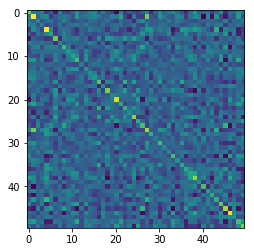

In [30]:
plt.imshow(np.cov(x, ddof=1))

In [35]:
np.linalg.eigvals(np.cov(x))

array([  1.06117235e+01 +0.00000000e+00j,
         9.19708015e+00 +0.00000000e+00j,
         7.61681326e+00 +0.00000000e+00j,
         7.11346751e+00 +0.00000000e+00j,
         5.78195340e+00 +0.00000000e+00j,
         6.12468396e+00 +0.00000000e+00j,
         3.90158120e+00 +0.00000000e+00j,
         3.00785399e+00 +0.00000000e+00j,
         3.13789957e+00 +0.00000000e+00j,
         1.14130023e-15 +0.00000000e+00j,
         8.69716098e-16 +2.82964977e-17j,
         8.69716098e-16 -2.82964977e-17j,
         6.31293666e-16 +4.46382643e-16j,
         6.31293666e-16 -4.46382643e-16j,
        -8.20039385e-16 +1.67525776e-16j,
        -8.20039385e-16 -1.67525776e-16j,
        -7.52225188e-16 +1.46166171e-16j,
        -7.52225188e-16 -1.46166171e-16j,
         6.14108591e-16 +0.00000000e+00j,
         1.18120652e-16 +4.72254848e-16j,
         1.18120652e-16 -4.72254848e-16j,
        -5.77113936e-16 +0.00000000e+00j,
        -3.60035756e-16 +2.78519029e-16j,
        -3.60035756e-16 -2.7851902

In [29]:
np.linalg.cholesky(np.cov(x, ddof=1))

LinAlgError: Matrix is not positive definite

In [24]:
np.logspace(3, 5, 10).astype('int')

array([  1000,   1668,   2782,   4641,   7742,  12915,  21544,  35938,
        59948, 100000])

In [36]:
asymptotic_entropy = []
datapoints = np.logspace(2, 4, 10).astype('int')
for n in tqdm(datapoints):
    x = np.random.randn(50, n)
    y = np.random.randn(21, n)
    mi = mutual_information(x, y)
    asymptotic_entropy.append(mi)

100%|██████████| 10/10 [00:00<00:00, 88.18it/s]


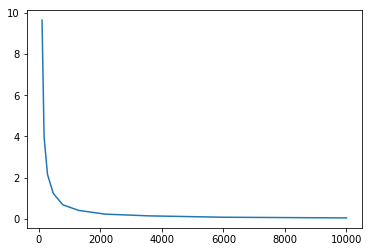

In [37]:
plt.plot(datapoints, asymptotic_entropy)

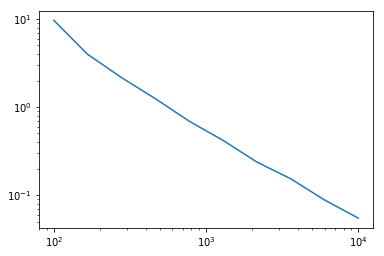

In [38]:
plt.plot(datapoints, asymptotic_entropy)
plt.yscale('log')
plt.xscale('log')

In [39]:
cov_x = np.cov(x, ddof=1)
cov_y = np.cov(y, ddof=1)
cov_xy = np.cov(np.vstack([x, y]), ddof=1)

entropy_x = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_x))
entropy_y = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_y))
entropy_xy = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_xy))


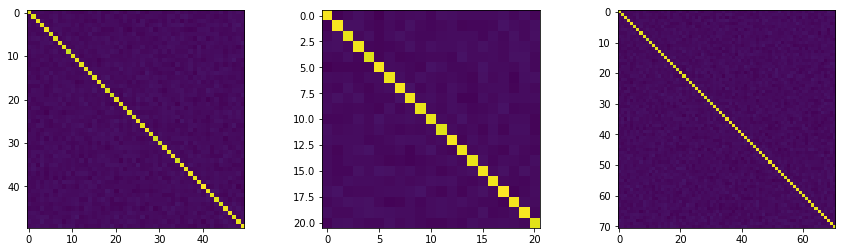

In [40]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.imshow(cov_x)
plt.subplot(1, 3, 2)
plt.imshow(cov_y)
plt.subplot(1, 3, 3)
plt.imshow(cov_xy)

In [41]:
entropy_x

70.802031484782006

In [42]:
entropy_y

29.831201664789429

In [43]:
entropy_xy

100.57859588755632

In [44]:
entropy_x + entropy_y - entropy_xy

0.054637262015120314

## Good reminder that we need lots of data to avoid overestimating MI!

In [71]:
N = 1000
hw = 0.5
cw = 0.5
spatial_signals = 10 * generate_spatial_signals(N)
noisy_signals = spatial_signals + 0.01 * np.random.randn(*spatial_signals.shape)
out = []
for s in spatial_signals:
    out.append(np.convolve(s, rf_model(hw, cw), mode='same'))
output = np.stack(out)
noisy_output = output + 0.4 * np.random.randn(*output.shape)

In [72]:
xy = np.vstack([spatial_signals.T, noisy_output.T])

In [73]:
cov_s = np.cov(spatial_signals.T, ddof=1)
cov_o = np.cov(noisy_output.T, ddof=1)
cov_so = np.cov(xy, ddof=1)

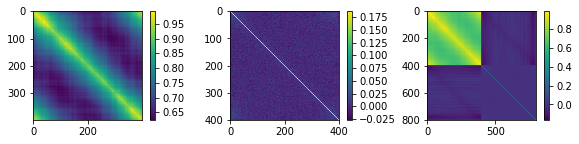

In [74]:
fig = plt.figure(figsize=(10,2))
plt.subplot(1, 3, 1)
plt.imshow(cov_s)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(cov_o)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(cov_so)
plt.colorbar()

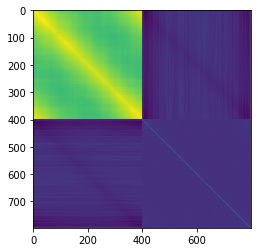

In [75]:
plt.imshow(cov_so)

In [85]:
mi = mutual_information(spatial_signals.T, noisy_output.T)

In [86]:
mi

12.69832293726563

In [87]:
N = 10000
hw = 0.5
cw = 0.5
spatial_signals = 10 * generate_spatial_signals(N)
noisy_signals = spatial_signals + 0.01 * np.random.randn(*spatial_signals.shape)
out = []
for s in spatial_signals:
    out.append(np.convolve(s, rf_model(hw, cw), mode='same'))
output = np.stack(out)
noisy_output = output + 0.4 * np.random.randn(*output.shape)

In [88]:
xy = np.vstack([spatial_signals.T, noisy_output.T])
cov_s = np.cov(spatial_signals.T, ddof=1)
cov_o = np.cov(noisy_output.T, ddof=1)
cov_so = np.cov(xy, ddof=1)

In [89]:
mi = mutual_information(spatial_signals.T, noisy_output.T)

In [90]:
mi

12.776582105874695

In [94]:
N = 10000
hw = 0.0
cw = 0.5
spatial_signals = 10 * generate_spatial_signals(N)
noisy_signals = spatial_signals + 0.01 * np.random.randn(*spatial_signals.shape)
out = []
for s in spatial_signals:
    out.append(np.convolve(s, rf_model(hw, cw), mode='same'))
output = np.stack(out)
noisy_output = output + 0.4 * np.random.randn(*output.shape)

xy = np.vstack([spatial_signals.T, noisy_output.T])
cov_s = np.cov(spatial_signals.T, ddof=1)
cov_o = np.cov(noisy_output.T, ddof=1)
cov_so = np.cov(xy, ddof=1)

mi = mutual_information(spatial_signals.T, noisy_output.T)

In [95]:
mi

10.688799192891565